In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from random import randint
from __future__ import division
from itertools import count
from numpy import linspace, loadtxt, ones, convolve
from matplotlib import dates
%matplotlib inline

In [5]:
df = pd.read_csv("C:\\users\\kim\\downloads\\r2\\http.csv")

In [6]:
from datetime import datetime
df['new_date'] = df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S').strftime("%m/%d/%Y"))

In [7]:
df['new_date'] = df['new_date'].astype(pd.datetime)

In [8]:
df.head()

,id,date,user,pc,url,new_date
0,{A5Z0-O7YI19HY-2327MTUD},01/04/2010 00:11:14,XAW0291,PC-1897,http://espn.go.com,01/04/2010
1,{I2D2-H2HE07ZC-7547MMBZ},01/04/2010 00:17:09,XAW0291,PC-1897,http://aol.com,01/04/2010
2,{A5I3-U0KO25JD-1385DSOT},01/04/2010 06:15:16,GOF0098,PC-5628,http://t.co,01/04/2010
3,{E4U0-Z3IA14TT-0368VHTQ},01/04/2010 06:15:48,GOF0098,PC-5628,http://expedia.com,01/04/2010
4,{Y6W8-R7RS54AX-7698XOES},01/04/2010 06:17:07,BTC0414,PC-1953,http://wordpress.com,01/04/2010


In [9]:
badurls = pd.read_csv("C:\\users\\kim\\documents\\blackurls.txt", delimiter='\t', skiprows=3, header=None)
badurls.columns = ['url']

In [10]:
badurls.head()

,url
0,.4everproxy.co
1,.abcangelsgeniusgolden.com
2,.absolutestreettheorypush.com
3,.accountingheadninegenius.com
4,.afcnsfpd.com


In [11]:
len(df)

7321105

In [12]:
#df2 = pd.DataFrame([['wikileaks.org']], columns=['url'])
#badurls = badurls.append(df2, ignore_index=True)
badurls[badurls['url']=='wikileaks.org']

,url
958,wikileaks.org


In [13]:
def foo(name):
    for url in badurls:
        if url in name:
            return '1'
        else:
            return '0'

df['bad'] = df['url'].apply(foo)

In [14]:
df['bad'].value_counts()

0    7321017
1         88
Name: bad, dtype: int64

In [15]:
df.loc[(df['url'] == 'http://wikileaks.org') & (df['bad'] == '0'), ['bad']] = '1'

In [16]:
df['bad'].value_counts()

0    7321014
1         91
Name: bad, dtype: int64

In [17]:
users = df['user'].unique()
len(users)

1000

In [18]:
users

array(['XAW0291', 'GOF0098', 'BTC0414', 'JCG0554', 'BFS0136', 'DCW0021',
       'EBP0026', 'SBH0386', 'LVL0139', 'GJC0019', 'FWM0066', 'GSH0070',
       'BKM0103', 'CSL0262', 'MLS0246', 'MHV0044', 'MBF0477', 'CPT0297',
       'KVL0272', 'RRN0611', 'GTH0674', 'DJP0523', 'YIS0037', 'SRG0235',
       'CBA0214', 'HAS0314', 'PMC0514', 'ZAS0597', 'GRK0410', 'TDC0252',
       'STS0318', 'DKP0058', 'DDC0009', 'SAD0163', 'KRH0377', 'BAT0268',
       'MRM0638', 'PPM0454', 'SDM0609', 'UNT0532', 'XDB0054', 'BBH0109',
       'JLH0041', 'JJM0727', 'JCW0114', 'NSP0048', 'HCH0089', 'IKD0392',
       'NBP0188', 'BJO0313', 'ORB0124', 'GDR0512', 'CKR0078', 'BDA0619',
       'PSM0171', 'TNH0237', 'ACK0013', 'ZJG0107', 'NHP0057', 'XJH0047',
       'KCD0131', 'GWR0092', 'MCN0429', 'AWH0068', 'KBS0345', 'CWA0210',
       'BAC0081', 'WCM0065', 'PKD0984', 'CES0014', 'JJD0020', 'SAB0194',
       'AKR0484', 'YAG0582', 'DHM0191', 'SCW0043', 'SKT0231', 'RLS0130',
       'DDH0123', 'BZB0608', 'LJH0733', 'EPG0010', 

In [22]:
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

In [40]:
def explain_anomalies(x, y, window_size, sigma=1.0):
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(x_i, y_i) for
                                                       x_i, y_i, avg_i in zip(x, y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

In [57]:
def explain_anomalies_rolling_std(x, y, window_size, sigma=1.0):
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    
    return {'stationary standard_deviation': round(std, 2),
            'anomalies_dict': collections.OrderedDict([(x_i, y_i)
                                                       for x_i, y_i, avg_i, rs_i in zip(x,
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}

In [92]:
def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="Corresponding Date", text_ylabel="Count of Websites Visited", applying_rolling_std=True):
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.")
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='blue')
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)

    # Query for the anomalies and plot the same
    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(x, y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(x, y, window_size=window_size, sigma=sigma_value)

    print("KEYS: ", events['anomalies_dict'].keys())
    x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
    print("Plotting the anomalies: ", x_anomaly)
    y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))

    plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

    # add grid and lines and enable the plot
    plt.grid(True)
    plt.show()

User:  KJP0113
Anomalies:  OrderedDict([(733973.0, 193)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


C:\Users\kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()
  
C:\Users\kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
C:\Users\kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
C:\Users\kim\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


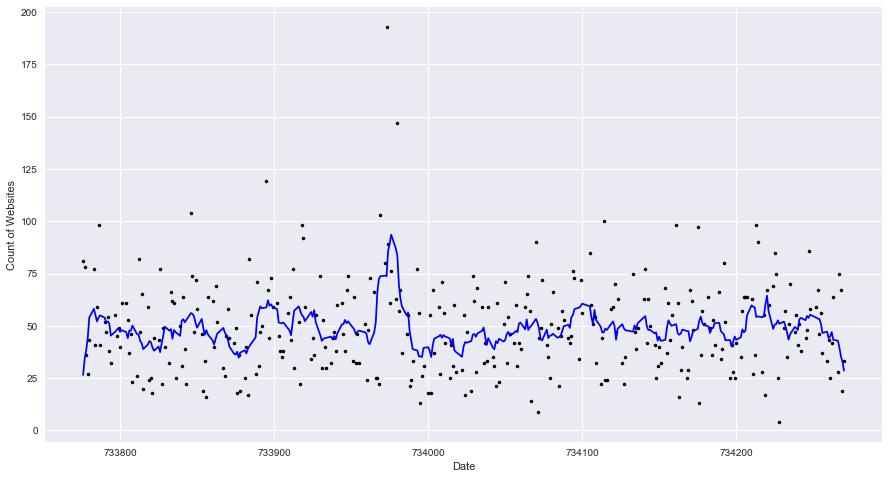

User:  SAB0456
Anomalies:  OrderedDict([(733980.0, 44)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


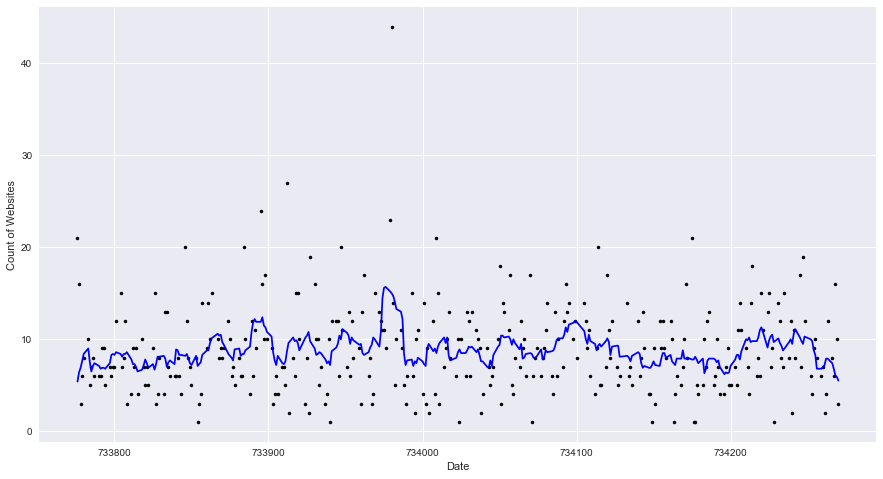

User:  KJH0667
Anomalies:  OrderedDict([(733895.0, 21)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


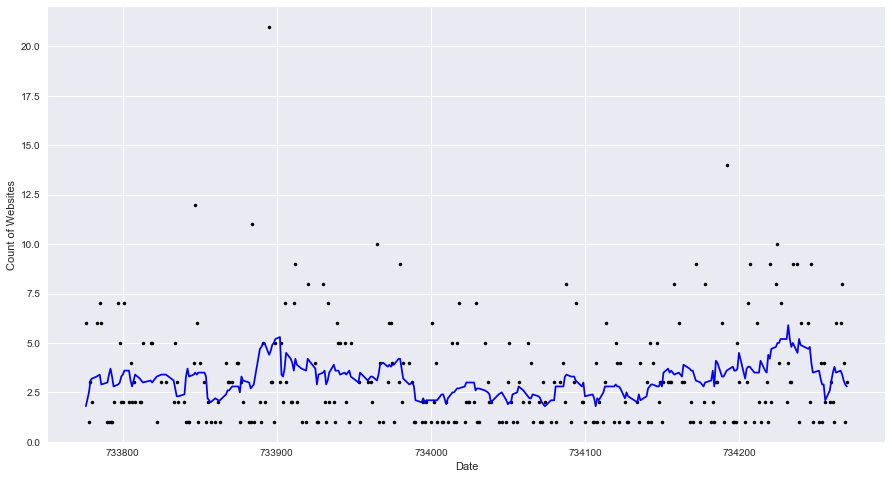

User:  DWC0958
Anomalies:  OrderedDict([(733980.0, 13)])
KEYS:  odict_keys([733777.0])
Plotting the anomalies:  [733777]


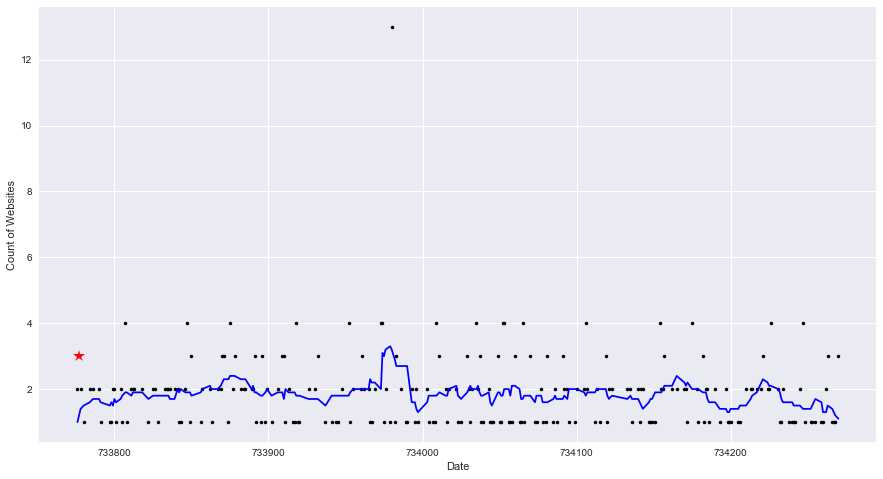

User:  KNM0794
Anomalies:  OrderedDict([(733930.0, 16)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


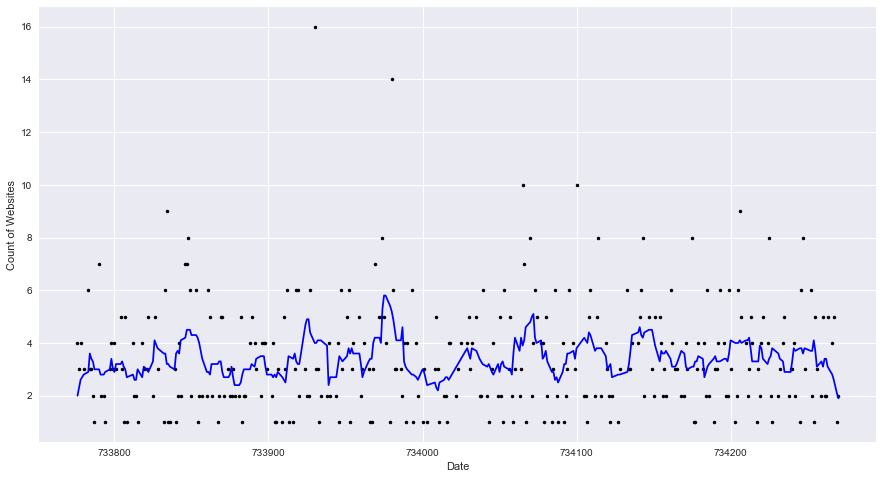

User:  AKI0758
Anomalies:  OrderedDict([(733973.0, 21)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


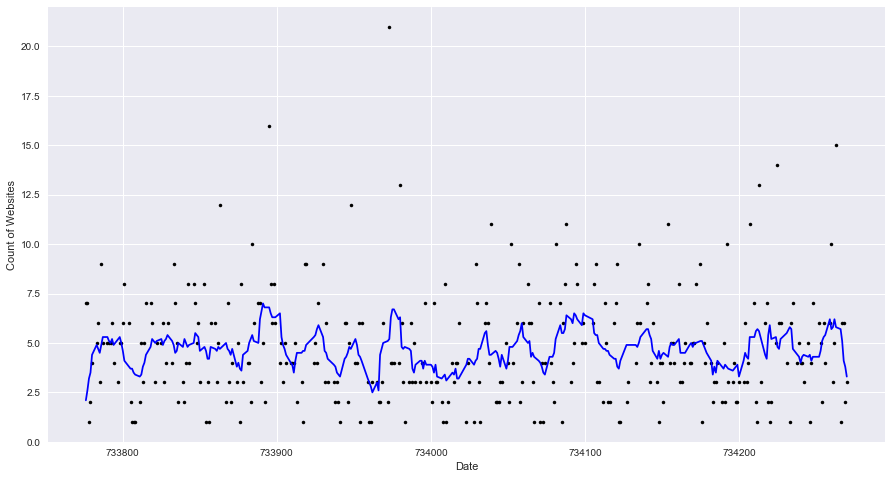

User:  GSH0651
Anomalies:  OrderedDict([(733973.0, 36)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


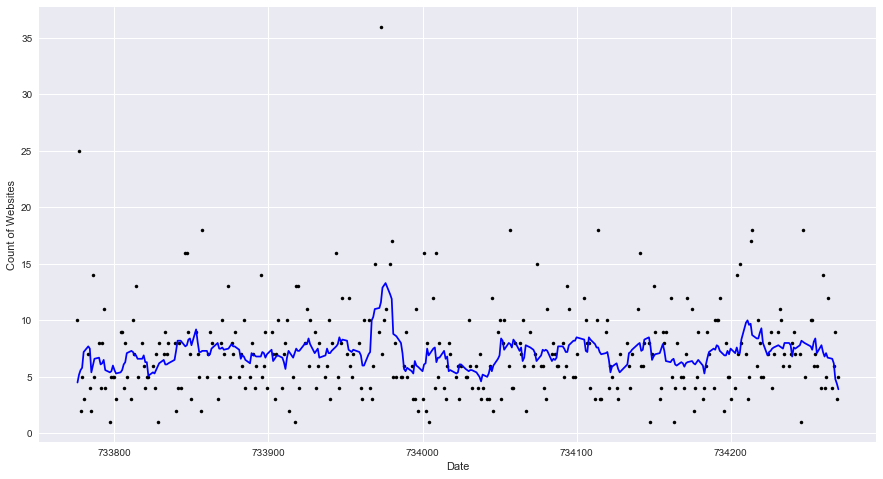

User:  KKD0509
Anomalies:  OrderedDict([(733969.0, 44)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


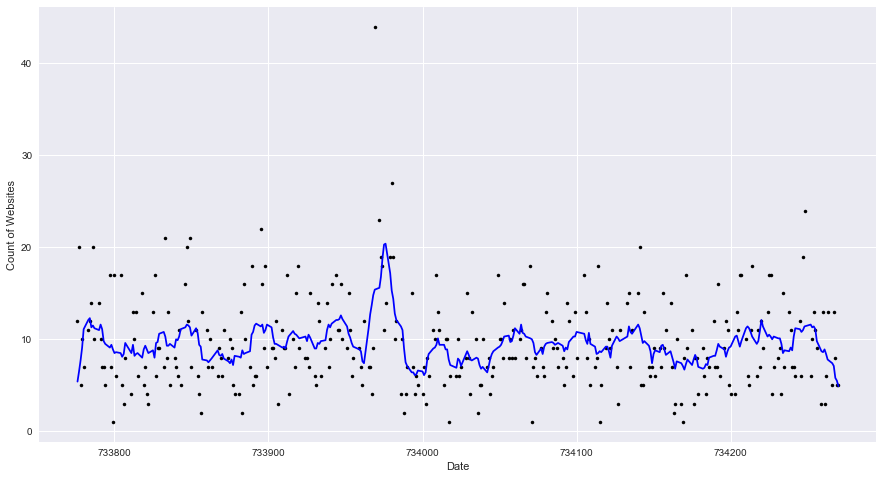

User:  WDM0884
Anomalies:  OrderedDict([(733980.0, 11)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


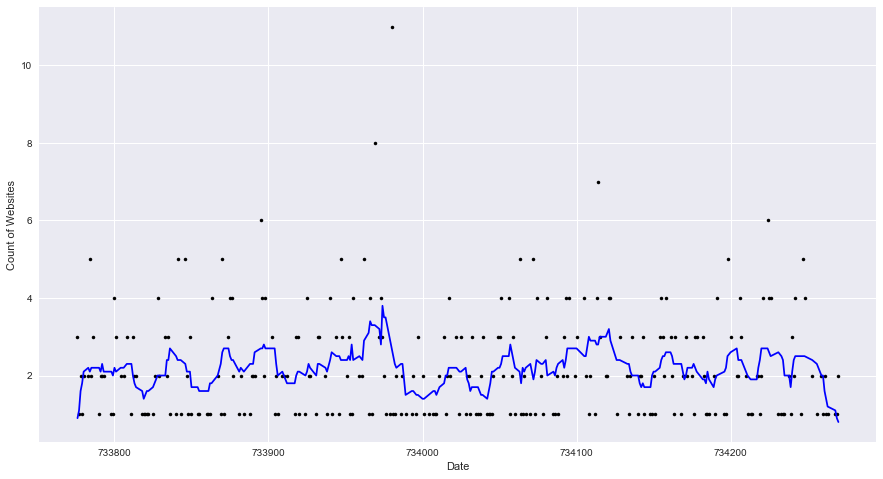

User:  DCM0505
Anomalies:  OrderedDict([(733973.0, 39)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


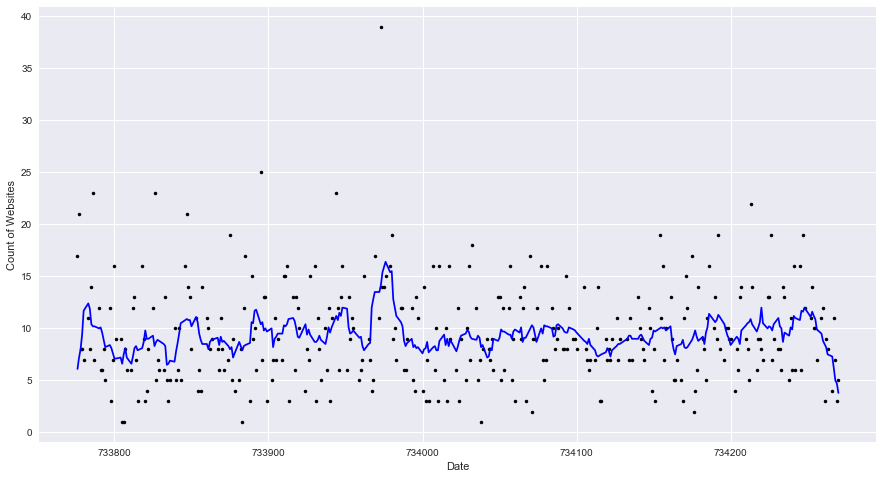

User:  YAH0843
Anomalies:  OrderedDict([(733973.0, 19)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


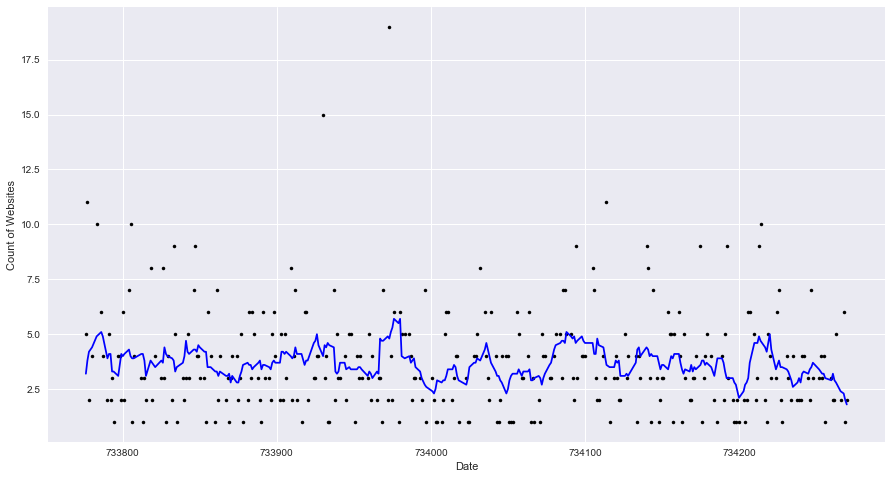

User:  AEG0812
Anomalies:  OrderedDict([(733969.0, 15)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


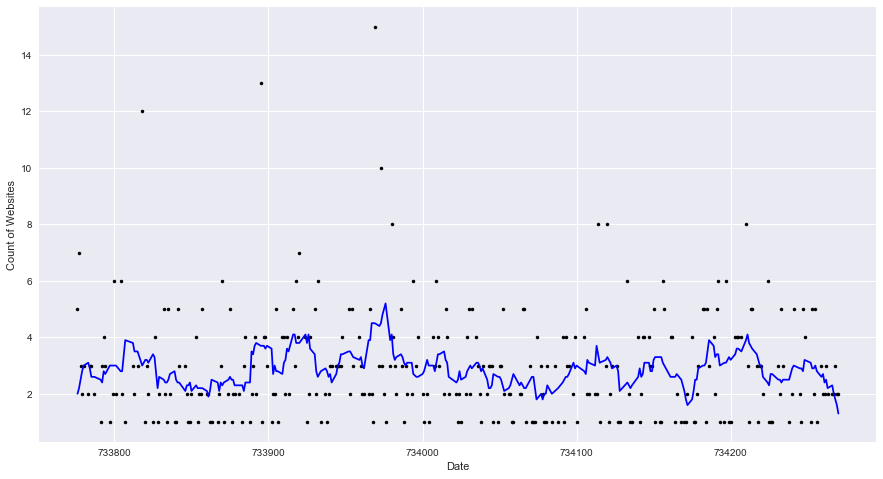

User:  BKG0241
Anomalies:  OrderedDict([(733973.0, 98)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


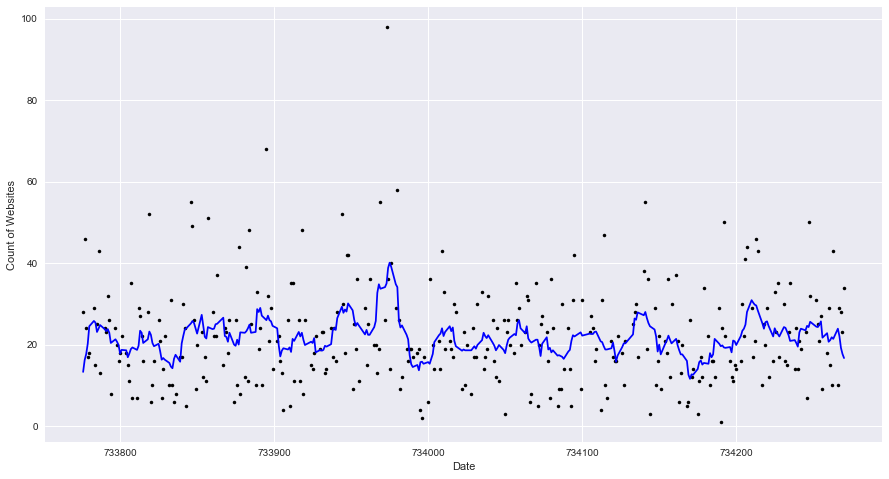

User:  POR0853
Anomalies:  OrderedDict([(734133.0, 15)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


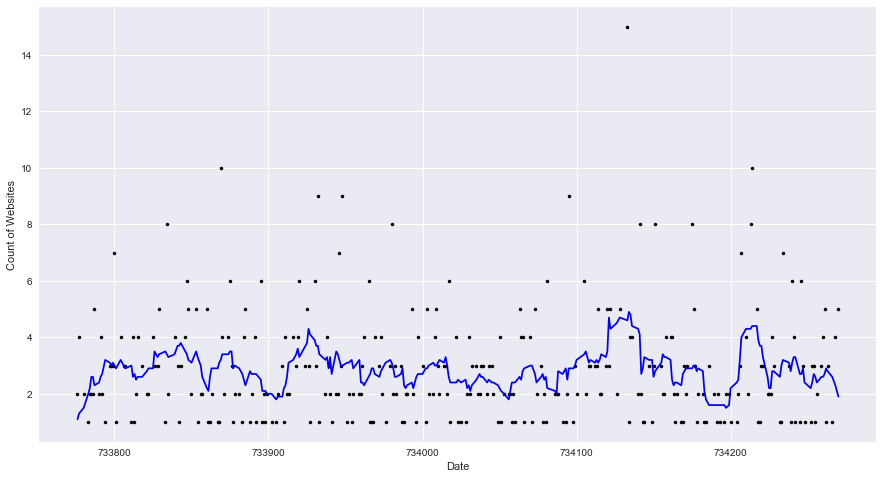

User:  BRC0607
Anomalies:  OrderedDict([(733973.0, 31)])
KEYS:  odict_keys([])
Plotting the anomalies:  []


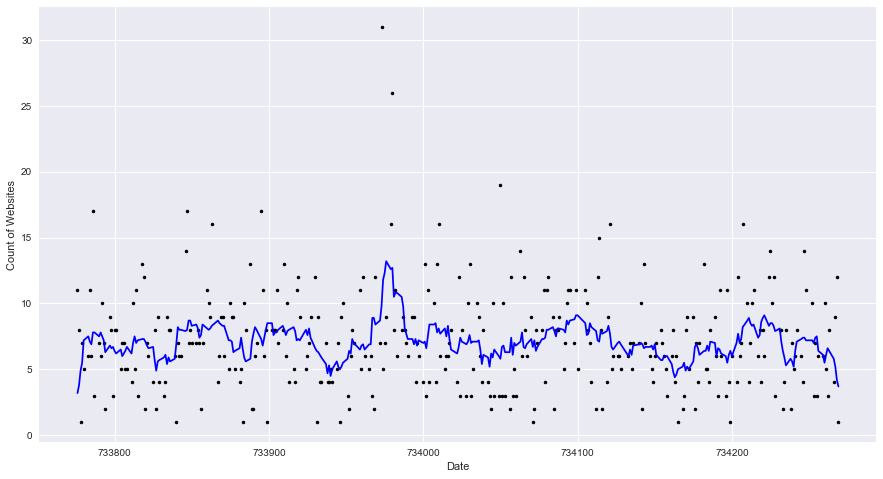

KeyboardInterrupt: 

In [93]:
i = 0
p = 0
for u in users:
    temp = df[df['user']==u]
    temp2 = temp.groupby(['new_date'])['url'].agg(['count']).reset_index().sort_values('new_date')
    temp2 = temp2.sort_values(by='new_date')
    temp2['new_date2'] = temp2['new_date'].apply(lambda x: dates.date2num(datetime.strptime(x, "%m/%d/%Y")))
    temp2 = temp2.sort_values(by='new_date2')
    x = temp2['new_date2']
    y = temp2['count']

    # plot the results
    events = explain_anomalies(x, y, window_size=10, sigma=5.5)
    if len(events['anomalies_dict']) > 0:
        print("User: ", u)
        print("Anomalies: ", events['anomalies_dict'])
        
        plot_results(x, y, window_size=10, text_xlabel="Date", sigma_value=3,text_ylabel="Count of Websites")
        p += 1

print("Total Number of Users with Anomalies: ", p)

User:  KJP0113
Anomalies:  OrderedDict([(733973.0, 193)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


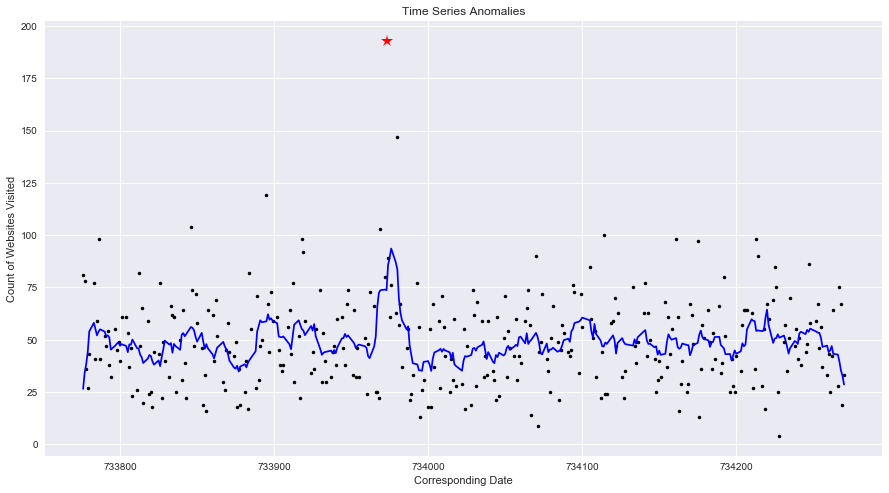

User:  SAB0456
Anomalies:  OrderedDict([(733980.0, 44)])
KEYS:  odict_keys([733980.0])
Plotting the anomalies:  [733980]


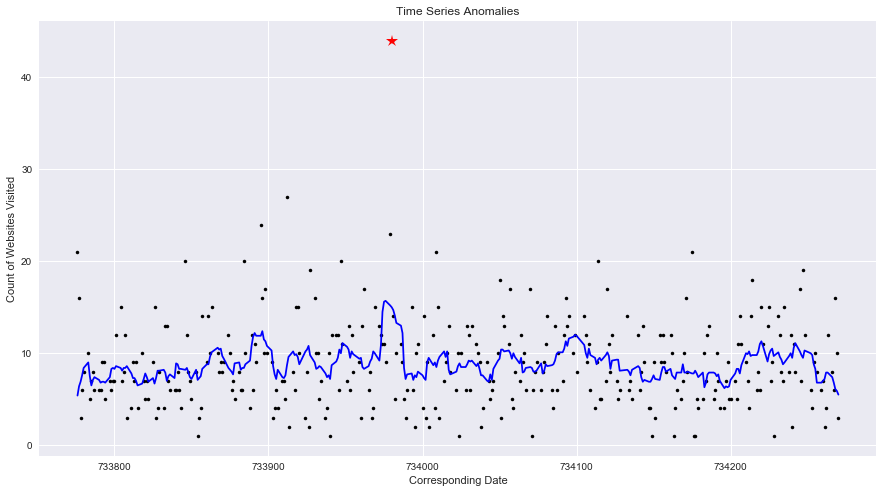

User:  KJH0667
Anomalies:  OrderedDict([(733895.0, 21)])
KEYS:  odict_keys([733895.0])
Plotting the anomalies:  [733895]


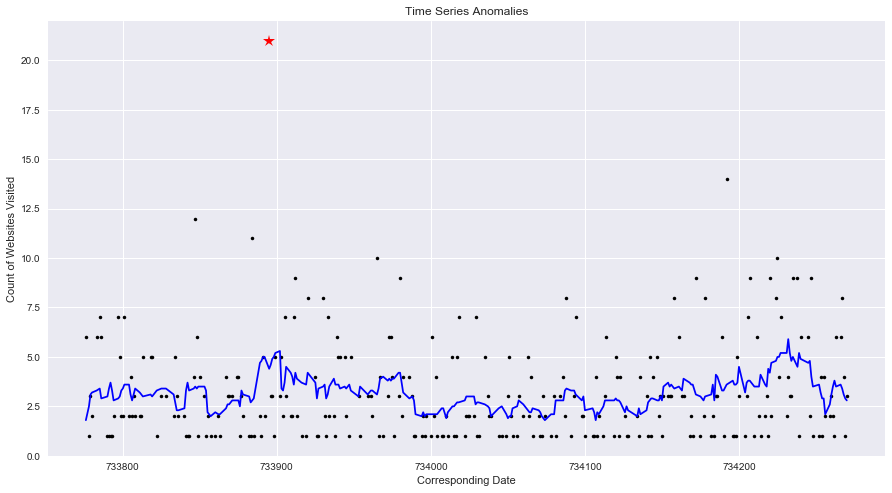

User:  DWC0958
Anomalies:  OrderedDict([(733980.0, 13)])
KEYS:  odict_keys([733980.0])
Plotting the anomalies:  [733980]


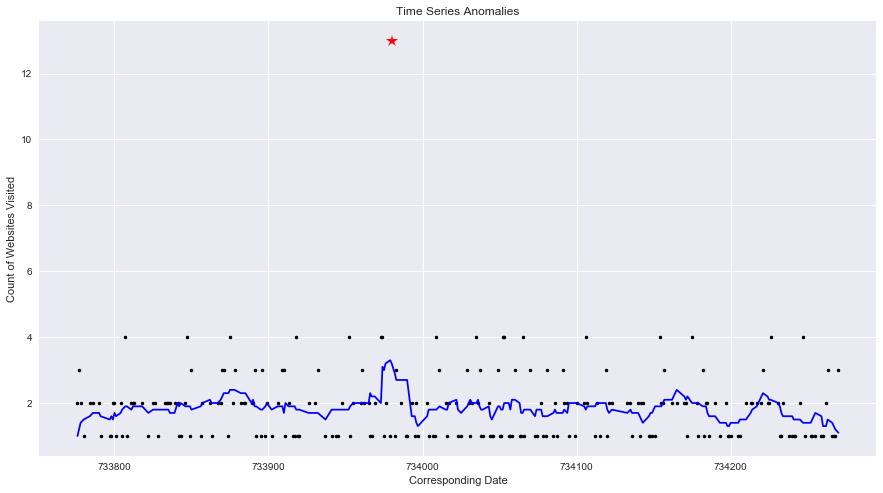

User:  KNM0794
Anomalies:  OrderedDict([(733930.0, 16)])
KEYS:  odict_keys([733930.0])
Plotting the anomalies:  [733930]


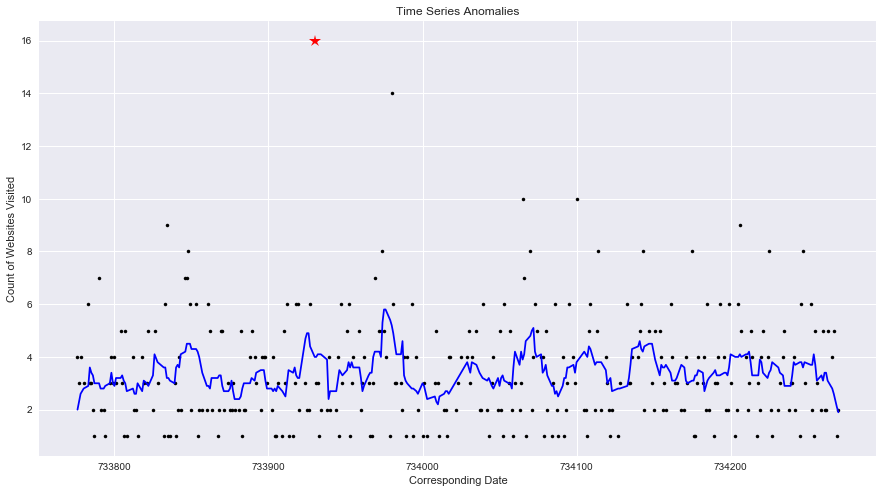

User:  AKI0758
Anomalies:  OrderedDict([(733973.0, 21)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


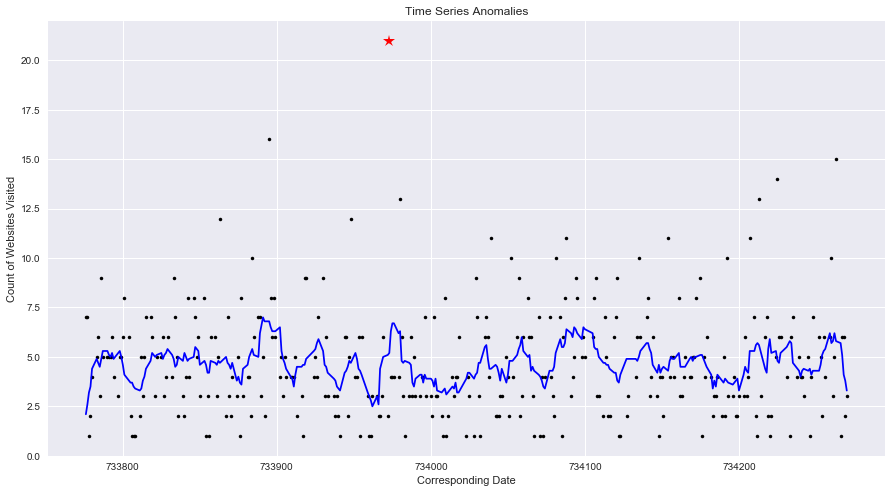

User:  GSH0651
Anomalies:  OrderedDict([(733973.0, 36)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


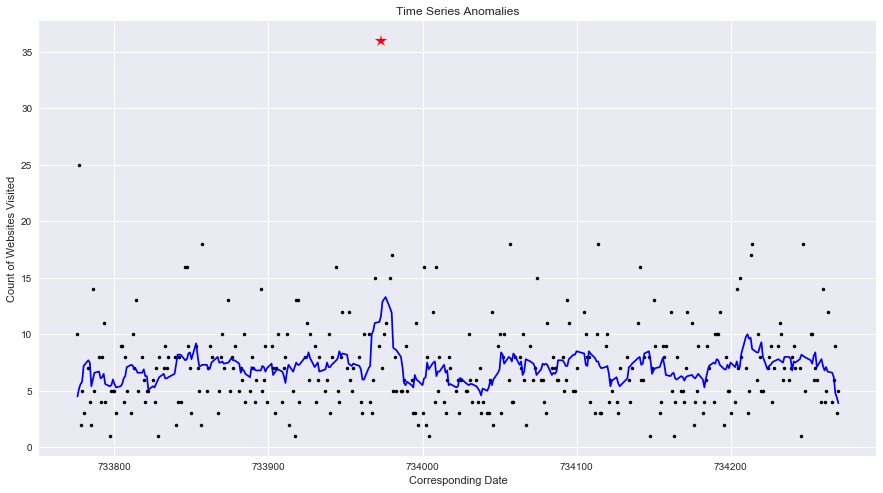

User:  KKD0509
Anomalies:  OrderedDict([(733969.0, 44)])
KEYS:  odict_keys([733969.0])
Plotting the anomalies:  [733969]


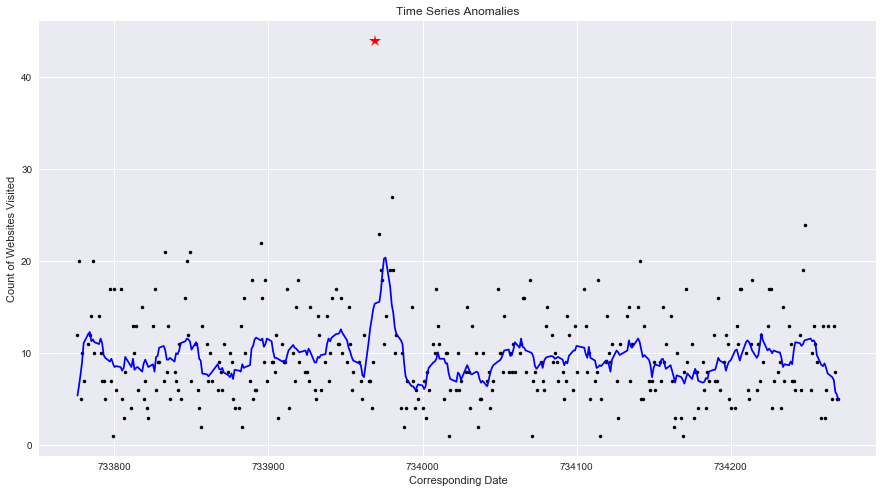

User:  WDM0884
Anomalies:  OrderedDict([(733980.0, 11)])
KEYS:  odict_keys([733980.0])
Plotting the anomalies:  [733980]


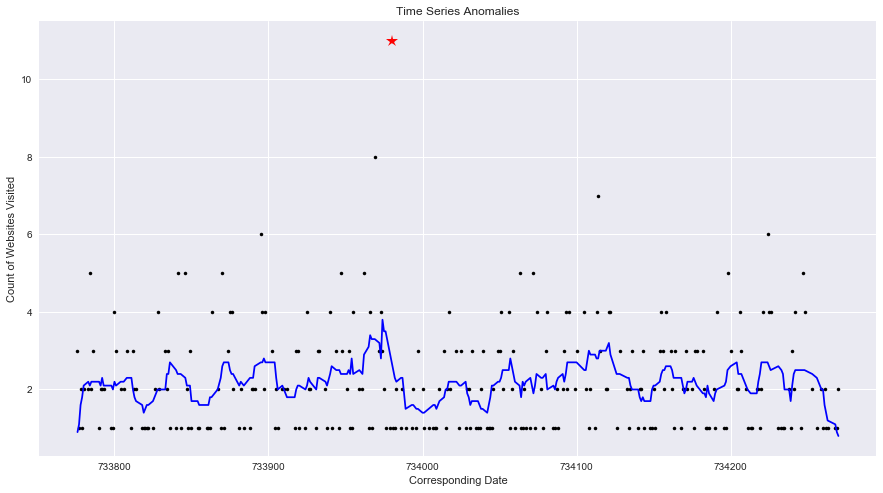

User:  DCM0505
Anomalies:  OrderedDict([(733973.0, 39)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


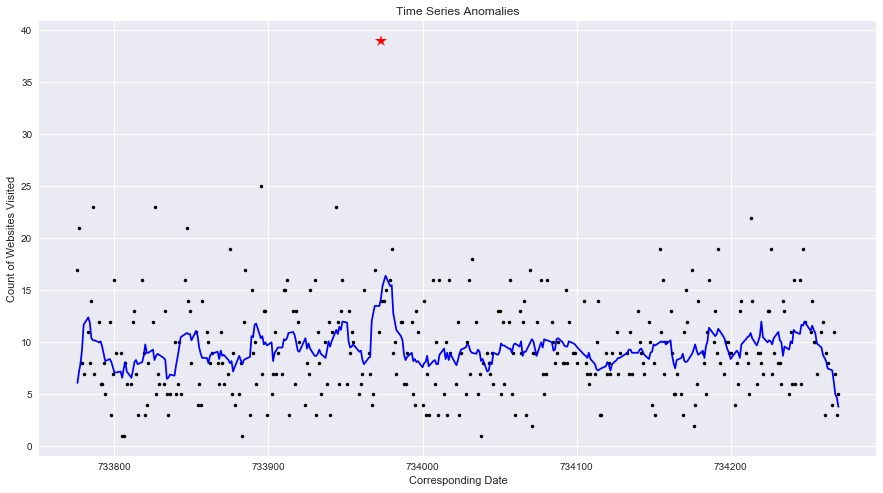

User:  YAH0843
Anomalies:  OrderedDict([(733973.0, 19)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


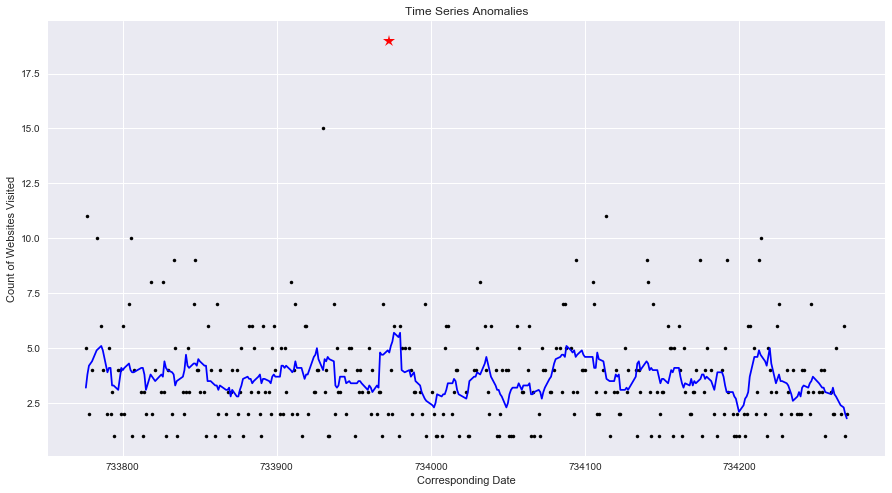

User:  AEG0812
Anomalies:  OrderedDict([(733969.0, 15)])
KEYS:  odict_keys([733969.0])
Plotting the anomalies:  [733969]


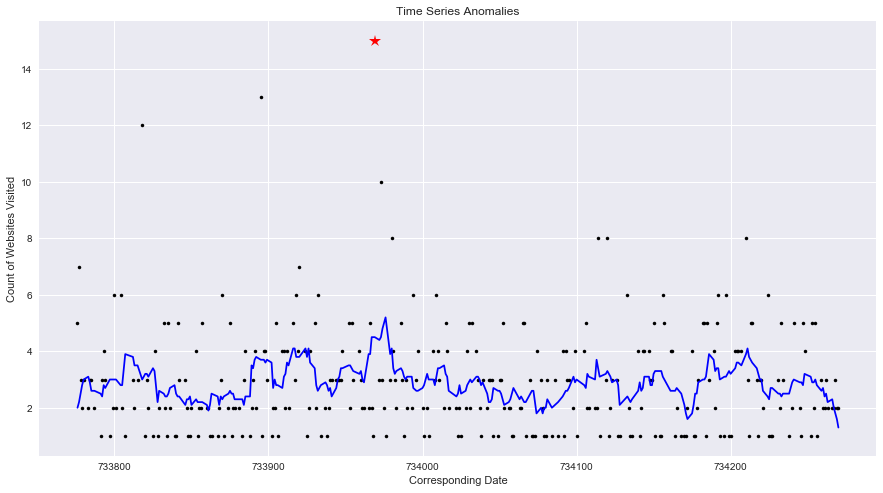

User:  BKG0241
Anomalies:  OrderedDict([(733973.0, 98)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


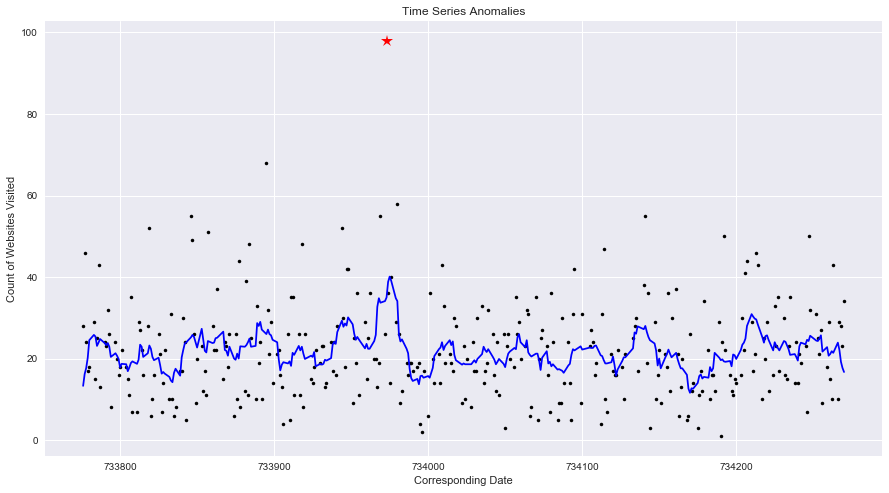

User:  POR0853
Anomalies:  OrderedDict([(734133.0, 15)])
KEYS:  odict_keys([734133.0])
Plotting the anomalies:  [734133]


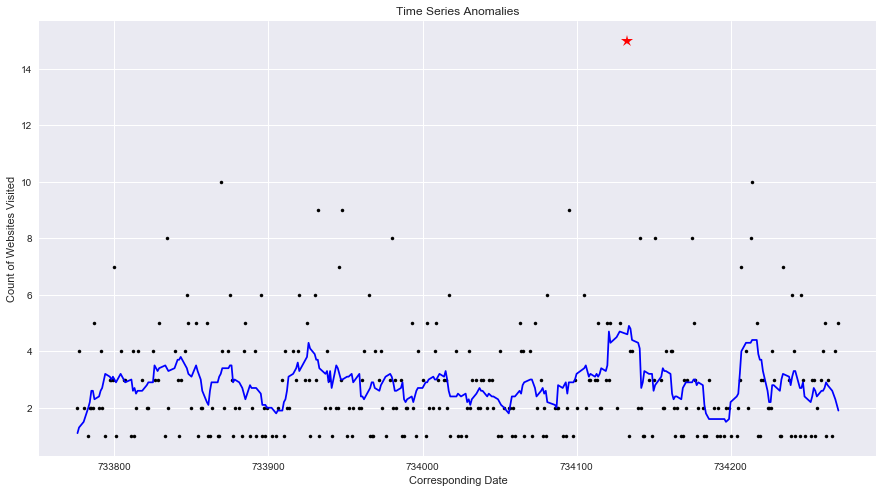

User:  BRC0607
Anomalies:  OrderedDict([(733973.0, 31)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


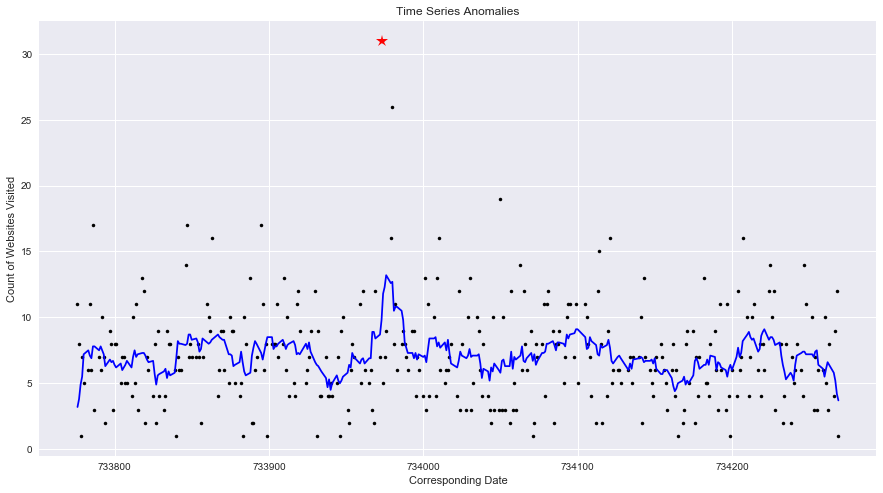

User:  JMJ0815
Anomalies:  OrderedDict([(733884.0, 17)])
KEYS:  odict_keys([733884.0])
Plotting the anomalies:  [733884]


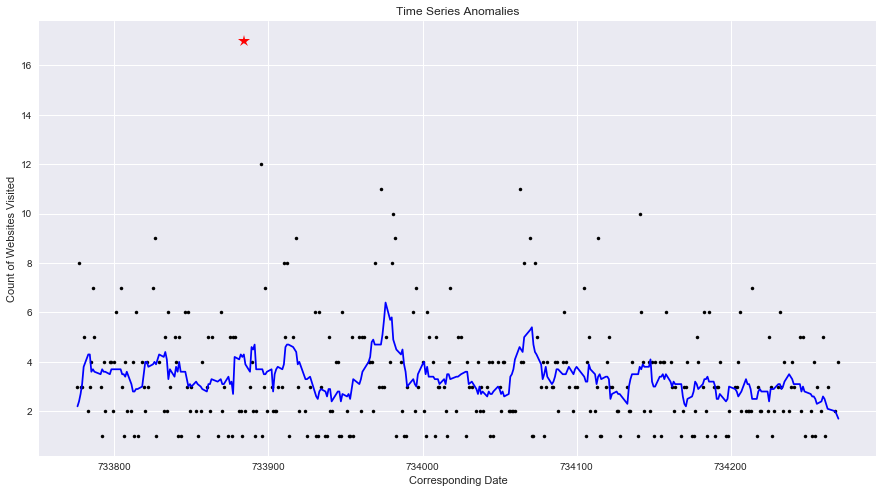

User:  EUH0628
Anomalies:  OrderedDict([(733846.0, 30)])
KEYS:  odict_keys([733846.0])
Plotting the anomalies:  [733846]


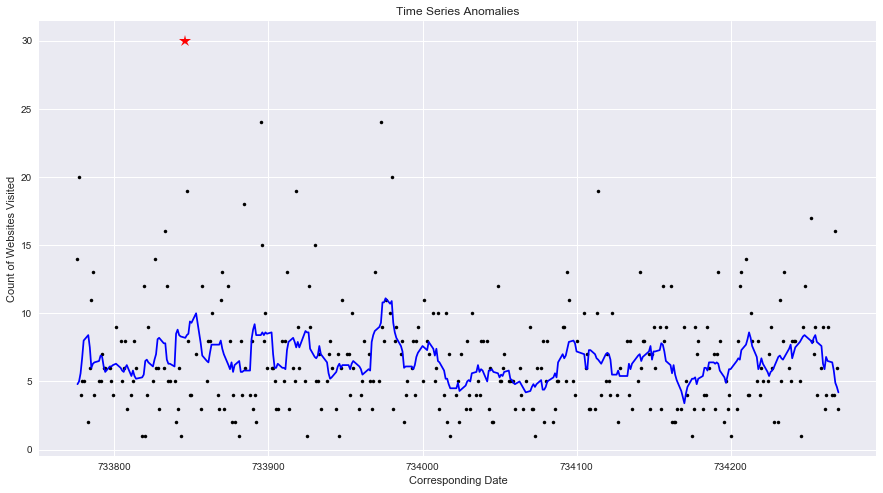

User:  JGM0518
Anomalies:  OrderedDict([(733895.0, 39)])
KEYS:  odict_keys([733895.0])
Plotting the anomalies:  [733895]


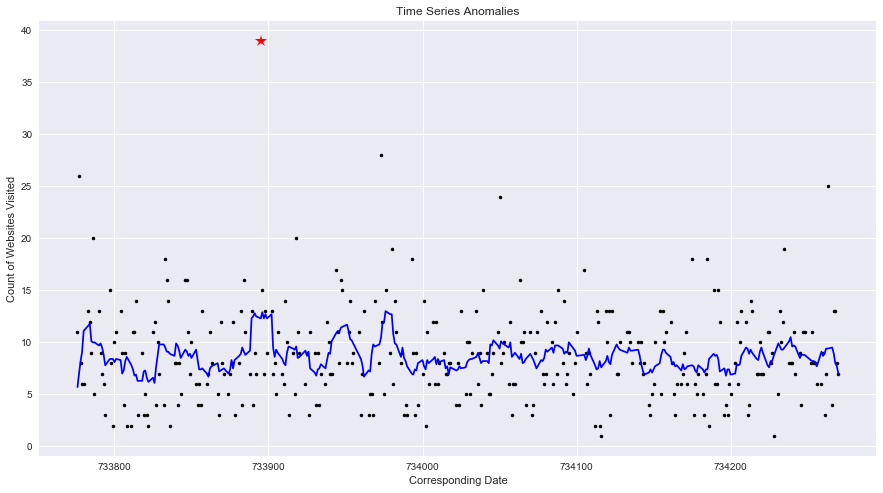

User:  OKS0845
Anomalies:  OrderedDict([(733973.0, 15)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


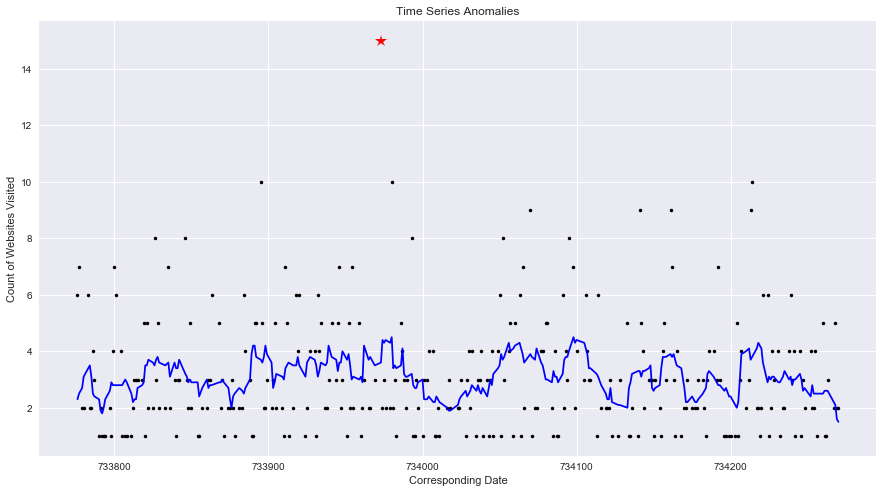

User:  MVB0228
Anomalies:  OrderedDict([(733973.0, 99)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


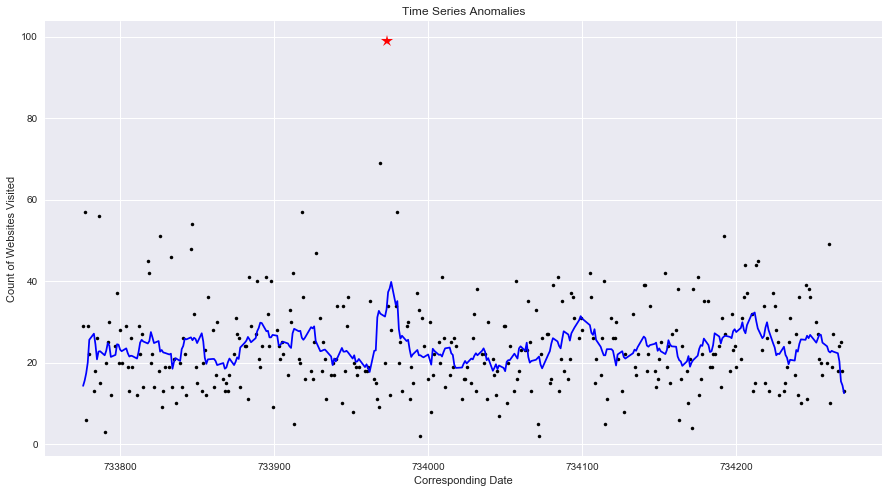

User:  LAG0755
Anomalies:  OrderedDict([(733909.0, 25)])
KEYS:  odict_keys([733909.0])
Plotting the anomalies:  [733909]


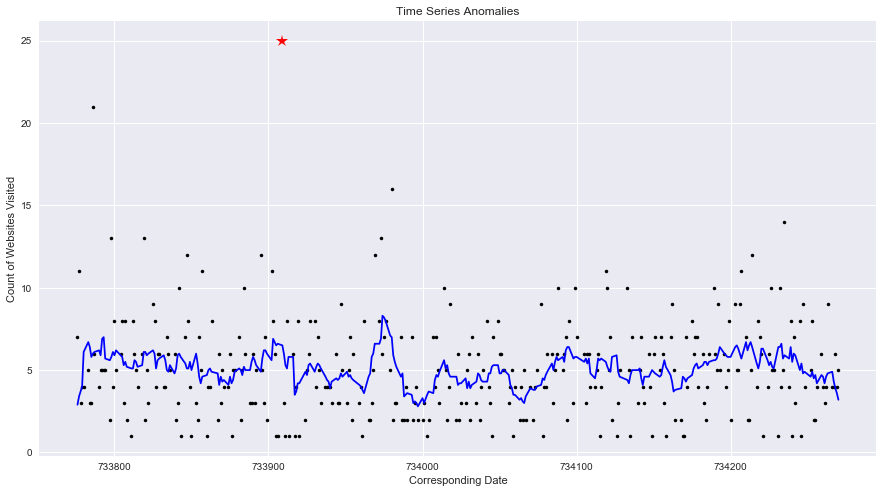

User:  NCS0844
Anomalies:  OrderedDict([(734114.0, 12)])
KEYS:  odict_keys([734114.0])
Plotting the anomalies:  [734114]


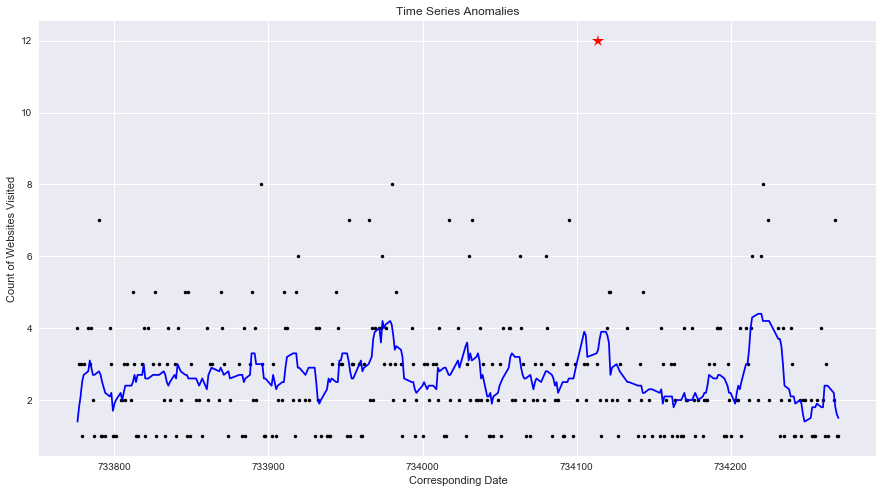

User:  CHY0696
Anomalies:  OrderedDict([(733786.0, 23)])
KEYS:  odict_keys([733786.0])
Plotting the anomalies:  [733786]


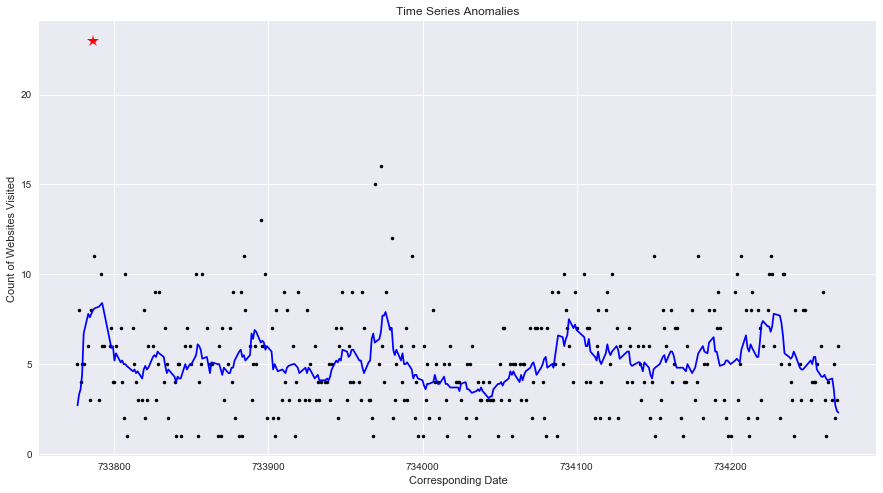

User:  QHH0839
Anomalies:  OrderedDict([(733846.0, 16)])
KEYS:  odict_keys([733846.0])
Plotting the anomalies:  [733846]


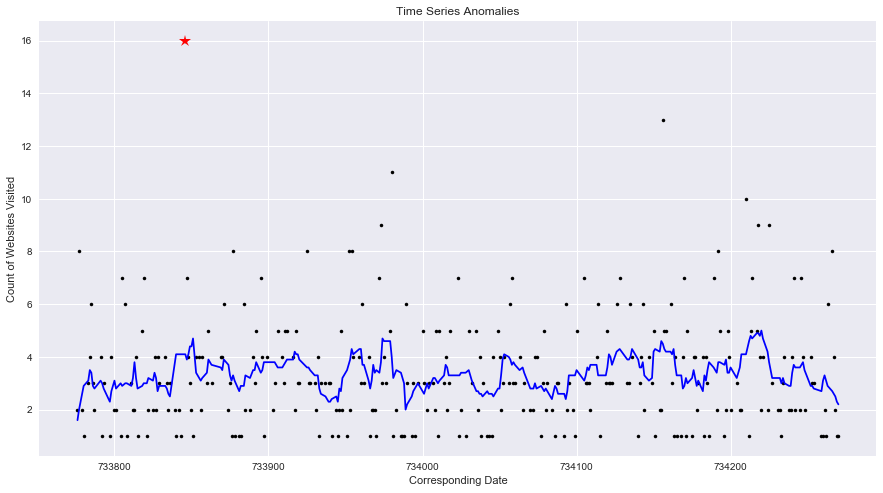

User:  WOM0924
Anomalies:  OrderedDict([(733969.0, 10)])
KEYS:  odict_keys([733969.0])
Plotting the anomalies:  [733969]


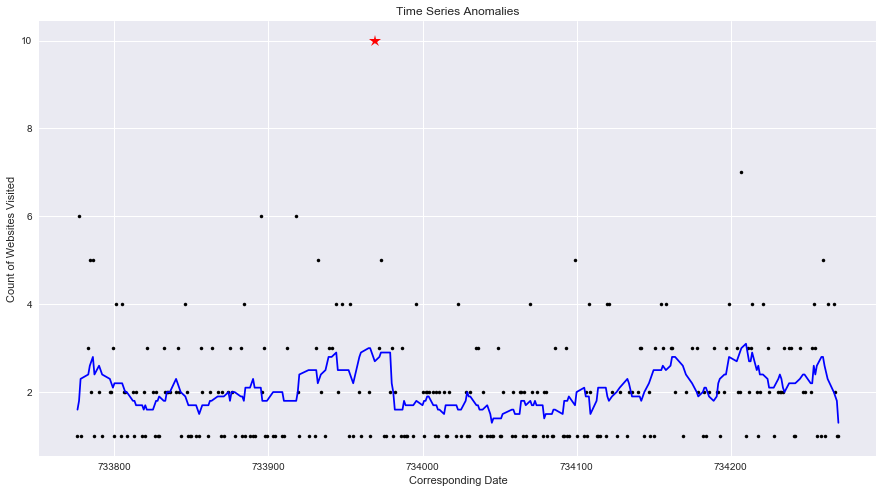

User:  KCM0496
Anomalies:  OrderedDict([(733973.0, 41)])
KEYS:  odict_keys([733973.0])
Plotting the anomalies:  [733973]


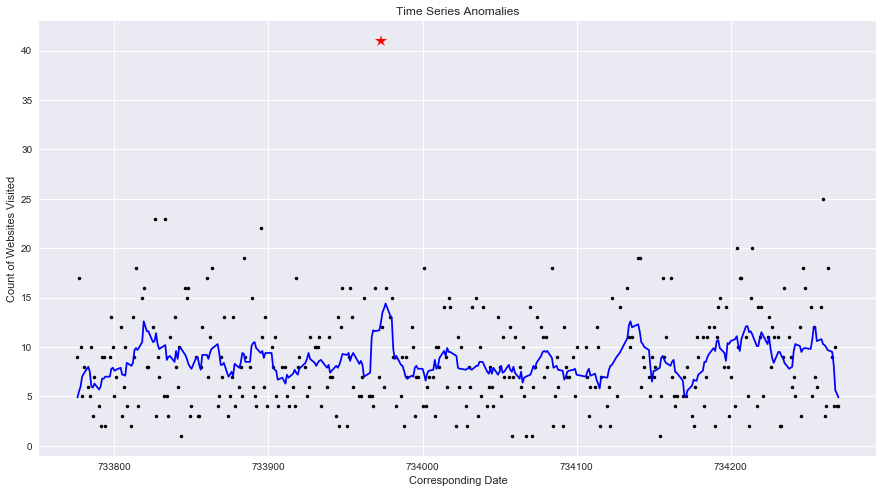

User:  AOK0962
Anomalies:  OrderedDict([(733826.0, 11)])
KEYS:  odict_keys([733826.0])
Plotting the anomalies:  [733826]


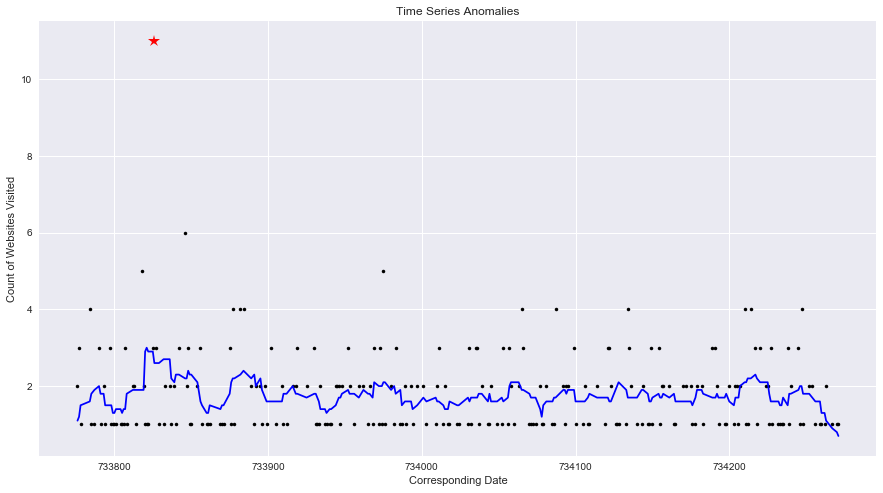

User:  FKC0831
Anomalies:  OrderedDict([(733895.0, 13)])
KEYS:  odict_keys([733895.0])
Plotting the anomalies:  [733895]


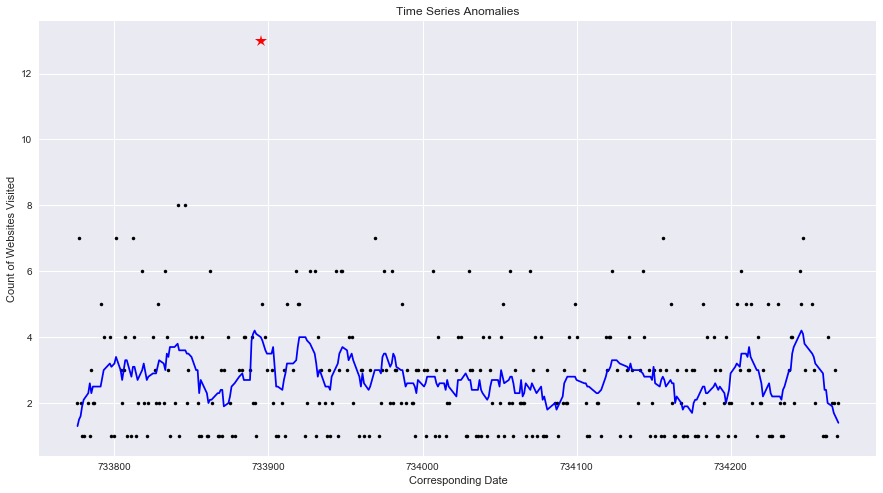

User:  CIH0756
Anomalies:  OrderedDict([(733895.0, 18)])
KEYS:  odict_keys([733895.0])
Plotting the anomalies:  [733895]


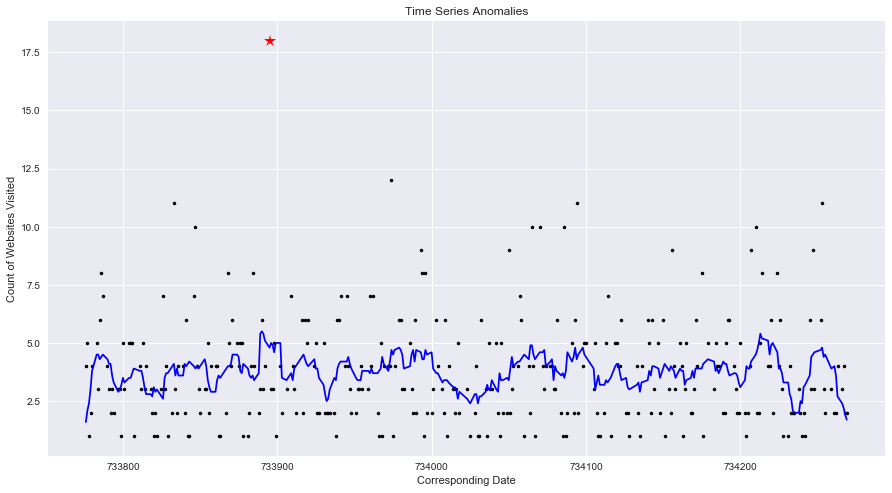

User:  JJG0996
Anomalies:  OrderedDict([(734106.0, 6)])
KEYS:  odict_keys([734106.0])
Plotting the anomalies:  [734106]


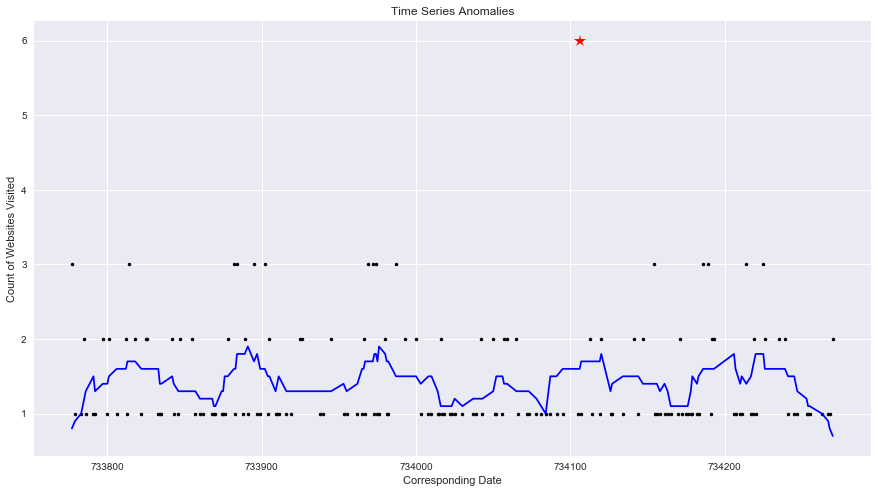

User:  BKM0979
Anomalies:  OrderedDict([(733980.0, 7)])
KEYS:  odict_keys([733980.0])
Plotting the anomalies:  [733980]


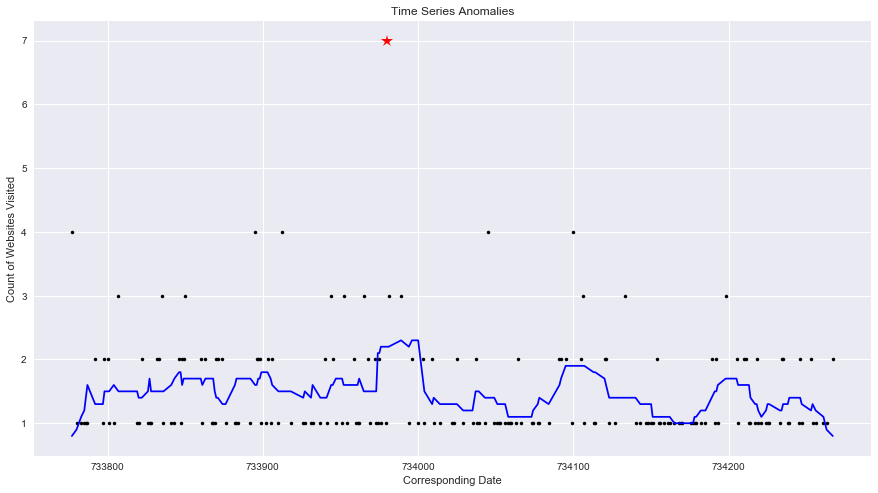

Total Number of Users with Anomalies:  31


In [97]:
i = 0
p = 0
for u in users:
    temp = df[df['user']==u]
    temp2 = temp.groupby(['new_date'])['url'].agg(['count']).reset_index().sort_values('new_date')
    temp2 = temp2.sort_values(by='new_date')
    temp2['new_date2'] = temp2['new_date'].apply(lambda x: dates.date2num(datetime.strptime(x, "%m/%d/%Y")))
    temp2 = temp2.sort_values(by='new_date2')
    x = temp2['new_date2']
    y = temp2['count']

    # plot the results
    events = explain_anomalies(x, y, window_size=10, sigma=5.5)
    if len(events['anomalies_dict']) > 0:
        print("User: ", u)
        print("Anomalies: ", events['anomalies_dict'])
    
        plt.figure(figsize=(15, 8))
        plt.plot(x, y, "k.")
        window_size=10
        sigma=5.5
        y_av = moving_average(y, window_size)
        plt.plot(x, y_av, color='blue')
        text_xlabel="Corresponding Date"
        text_ylabel="Count of Websites Visited"
        plt.title("Time Series Anomalies")
        plt.xlabel(text_xlabel)
        plt.ylabel(text_ylabel)

        # Query for the anomalies and plot the same
        print("KEYS: ", events['anomalies_dict'].keys())
        x_anomaly = np.fromiter(events['anomalies_dict'].keys(), dtype=int, count=len(events['anomalies_dict']))
        print("Plotting the anomalies: ", x_anomaly)
        y_anomaly = np.fromiter(events['anomalies_dict'].values(), dtype=float,
                                            count=len(events['anomalies_dict']))

        plt.plot(x_anomaly, y_anomaly, "r*", markersize=12)

        # add grid and lines and enable the plot
        plt.grid(True)
        plt.show()
        
        p += 1

print("Total Number of Users with Anomalies: ", p)